# Articles
https://keras.io/guides/transfer_learning/
https://keras.io/guides/training_with_built_in_methods/
https://www.youtube.com/watch?v=4umFSRPx-94&ab_channel=DigitalSreeni
https://www.tensorflow.org/guide/saved_model
https://github.com/UCSD-E4E/PyHa/blob/Microfaune_Retraining/Microfaune_Retraining-Copy1.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np

In [3]:
train = True

## Preprocess and load data
According to `config.py` and `checkpoints/README.md` for V2.1:  
- Model training input size: 144000 = 48000 x 3 = sample rate x num chunks  
- Model training output size: 2434 = 2424 bird classes + 10 non-event classes
- Visualize using [Netron](https://netron.app/)

In [4]:
import librosa

def splitSignal(sig, rate, overlap, seconds=3.0, minlen=1.5):

    # Split signal with overlap
    sig_splits = []
    for i in range(0, len(sig), int((seconds - overlap) * rate)):
        split = sig[i:i + int(seconds * rate)]

        # End of signal?
        if len(split) < int(minlen * rate):
            break
        
        # Signal chunk too short? Fill with zeros.
        if len(split) < int(rate * seconds):
            temp = np.zeros((int(rate * seconds)))
            temp[:len(split)] = split
            split = temp
        
        sig_splits.append(split)

    return sig_splits

def readAudioData(path, overlap, sample_rate=48000):

    #print('READING AUDIO DATA...', end=' ', flush=True)

    # Open file with librosa (uses ffmpeg or libav)
    try:
        sig, rate = librosa.load(path, sr=sample_rate, mono=True, res_type='kaiser_fast')
        clip_length = librosa.get_duration(y=sig, sr=rate)
    except:
        return 0
    # Split audio into 3-second chunks
    chunks = splitSignal(sig, rate, overlap)

    print('DONE! READ', str(len(chunks)), 'CHUNKS.')

    return chunks, clip_length

import pandas as pd
import numpy as np


#TODO Add mutliple species support for ROC curves 
def annotation_chunker_no_duplicates(kaleidoscope_df, chunk_length, include_no_bird=False, bird=None):
    """
    Function that converts a Kaleidoscope-formatted Dataframe containing 
    annotations to uniform chunks of chunk_length. If there
    are mutliple bird species in the same clip, this function creates chunks
    for the more confident bird species.

    Note: if all or part of an annotation covers the last < chunk_length
    seconds of a clip it will be ignored. If two annotations overlap in 
    the same 3 second chunk, both are represented in that chunk
    Args:
        kaleidoscope_df (Dataframe)
            - Dataframe of annotations in kaleidoscope format

        chunk_length (int)
            - duration to set all annotation chunks
    Returns:
        Dataframe of labels with chunk_length duration 
        (elements in "OFFSET" are divisible by chunk_length).
    """

    #Init list of clips to cycle through and output dataframe
    #kaleidoscope_df["FILEPATH"] =  kaleidoscope_df["FOLDER"] + kaleidoscope_df["IN FILE"] 
    kaleidoscope_df['FILEPATH'] = kaleidoscope_df.loc[:,['FOLDER','IN FILE']].sum(axis=1)
    clips = kaleidoscope_df["FILEPATH"].unique()
    df_columns = {'FOLDER': 'str', 'IN FILE' :'str', 'CLIP LENGTH' : 'float64', 'CHANNEL' : 'int64', 'OFFSET' : 'float64',
                'DURATION' : 'float64', 'SAMPLE RATE' : 'int64','MANUAL ID' : 'str'}
    output_df = pd.DataFrame({c: pd.Series(dtype=t) for c, t in df_columns.items()})
    
    # going through each clip
    for clip in clips:
        clip_df = kaleidoscope_df[kaleidoscope_df["FILEPATH"] == clip]
        path = clip_df["FOLDER"].unique()[0]
        file = clip_df["IN FILE"].unique()[0]
        birds = clip_df["MANUAL ID"].unique()
        sr = clip_df["SAMPLE RATE"].unique()[0]
        clip_len = clip_df["CLIP LENGTH"].unique()[0]

        # quick data sanitization to remove very short clips
        # do not consider any chunk that is less than chunk_length
        if clip_len < chunk_length:
            continue
        potential_annotation_count = int(clip_len)//int(chunk_length)

        # going through each species that was ID'ed in the clip
        arr_len = int(clip_len*1000)
        species_df = clip_df#[clip_df["MANUAL ID"] == bird]
        human_arr = np.zeros((arr_len))
        # looping through each annotation
        #print("========================================")
        for annotation in species_df.index:
            #print(species_df["OFFSET"][annotation])
            minval = int(round(species_df["OFFSET"][annotation] * 1000, 0))
            # Determining the end of a human label
            maxval = int(
                round(
                    (species_df["OFFSET"][annotation] +
                        species_df["DURATION"][annotation]) *
                    1000,
                    0))
            # Placing the label relative to the clip
            human_arr[minval:maxval] = 1
        # performing the chunk isolation technique on the human array

        for index in range(potential_annotation_count):
            #print("=======================")
            #print("-----------------------------------------")
            #print(index)
            chunk_start = index * (chunk_length*1000)
            chunk_end = min((index+1)*chunk_length*1000,arr_len)
            chunk = human_arr[int(chunk_start):int(chunk_end)]
            if max(chunk) >= 0.5:
                #Get row data
                row = pd.DataFrame(index = [0])
                annotation_start = chunk_start / 1000

                #Handle birdnet output edge case
                #print("-------------------------------------------")
                #print(sum(clip_df["DURATION"] == 3))
                #print(sum(clip_df["DURATION"] == 3)/clip_df.shape[0])
                #print("-------------------------------------------")
                if(sum(clip_df["DURATION"] == 3)/clip_df.shape[0] == 1):
                    #print("Processing here duration")
                    overlap = (clip_df["OFFSET"]+0.5 >= (annotation_start)) & (clip_df["OFFSET"]-0.5 <= (annotation_start))
                    annotation_df = clip_df[overlap]
                    #print(annotation_start, np.array(clip_df["OFFSET"]), overlap)
                    #print(annotation_df)
                else:
                    #print("Processing here")
                    overlap = is_overlap(clip_df["OFFSET"], clip_df["OFFSET"] + clip_df["DURATION"], annotation_start, annotation_start + chunk_length)
                    #print(overlap)
                    annotation_df = clip_df[overlap]
                    #print(annotation_df)
                
                #updating the dictionary
                if ('CONFIDENCE' in clip_df.columns):
                    annotation_df = annotation_df.sort_values(by="CONFIDENCE", ascending=False)
                    row["CONFIDENCE"] = annotation_df.iloc[0]["CONFIDENCE"]
                else:
                    #The case of manual id, or there is an annotation with no known confidence
                    row["CONFIDENCE"] = 1
                row["FOLDER"] = path
                row["IN FILE"] = file
                row["CLIP LENGTH"] = clip_len
                row["OFFSET"] = annotation_start
                row["DURATION"] = chunk_length
                row["SAMPLE RATE"] = sr
                row["MANUAL ID"] = annotation_df.iloc[0]["MANUAL ID"] 
                row["CHANNEL"] = 0
                output_df = pd.concat([output_df,row], ignore_index=True)
            elif(include_no_bird):
                #print(max(chunk))
                #Get row data
                row = pd.DataFrame(index = [0])
                annotation_start = chunk_start / 1000

                #updating the dictionary
                row["CONFIDENCE"] = 0
                row["FOLDER"] = path
                row["IN FILE"] = file
                row["CLIP LENGTH"] = clip_len
                row["OFFSET"] = annotation_start
                row["DURATION"] = chunk_length
                row["SAMPLE RATE"] = sr
                row["MANUAL ID"] = "no bird"
                row["CHANNEL"] = 0
                output_df = pd.concat([output_df,row], ignore_index=True)
    
    return output_df


def is_overlap(offset_df, end_df, chunk_start, chunk_end):
    is_both_before = (chunk_end < offset_df) & (chunk_start < offset_df)
    is_both_after = (end_df < chunk_end) & (end_df < chunk_start)
    return (~is_both_before) & (~is_both_after)
    
    
    interval = pd.Interval(left=offset_df, right=end_df)
    print(interval)


def split_save_files(dataframe_of_data):
    chunked_df = annotation_chunker_no_duplicates(dataframe_of_data, 3, include_no_bird=True)
    
    
    chunked_df.apply()
    



In [5]:
#chunks,clip_length  = readAudioData("./Data/code-testing/XC628854 - Yellow-olive Flatbill - Tolmomyias sulphurescens.mp3", 0, sample_rate=48000)

In [6]:
import pandas as pd
data = pd.read_csv("C:/Users/seanh/Desktop/E4E/passive-acoustic-biodiversity/BirdNET-Analyzer/COSMOS_Microfaune-Filename_Labels_100.csv")
chunked_df = annotation_chunker_no_duplicates(data, 3, include_no_bird=True)
chunked_df

,FOLDER,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID,CONFIDENCE
0,../all_10_species/,XC536709 - Slate-throated Whitestart - Myiobor...,40.437551,0,0.0,3.0,44100,Myioborus miniatus,1.0
1,../all_10_species/,XC536709 - Slate-throated Whitestart - Myiobor...,40.437551,0,3.0,3.0,44100,Myioborus miniatus,1.0
2,../all_10_species/,XC536709 - Slate-throated Whitestart - Myiobor...,40.437551,0,6.0,3.0,44100,Myioborus miniatus,1.0
3,../all_10_species/,XC536709 - Slate-throated Whitestart - Myiobor...,40.437551,0,9.0,3.0,44100,Myioborus miniatus,1.0
4,../all_10_species/,XC536709 - Slate-throated Whitestart - Myiobor...,40.437551,0,12.0,3.0,44100,Myioborus miniatus,1.0
...,...,...,...,...,...,...,...,...,...
38641,../all_10_species/,XC519088 - Rufous-collared Sparrow - Zonotrich...,24.293878,0,9.0,3.0,44100,Zonotrichia capensis,1.0
38642,../all_10_species/,XC519088 - Rufous-collared Sparrow - Zonotrich...,24.293878,0,12.0,3.0,44100,no bird,0.0
38643,../all_10_species/,XC519088 - Rufous-collared Sparrow - Zonotrich...,24.293878,0,15.0,3.0,44100,no bird,0.0
38644,../all_10_species/,XC519088 - Rufous-collared Sparrow - Zonotrich...,24.293878,0,18.0,3.0,44100,no bird,0.0


In [7]:
to_file = pd.read_csv("C:/Users/seanh/Desktop/e4e/passive-acoustic-biodiversity/BirdNET-Analyzer/Data/cosmos/automated_cosmos_tweety_to_file.csv")
classes_of_interest = np.unique(to_file["MANUAL ID"]) #np.append("no bird", np.unique(to_file["MANUAL ID"])) #np.unique(to_file["MANUAL ID"]) #

In [8]:

chunked_df = chunked_df[(chunked_df["MANUAL ID"].isin(classes_of_interest))]#["MANUAL_ID"] = "bird"
len(np.unique(chunked_df["MANUAL ID"]))

10

In [9]:
manual_df = pd.read_csv("C:/Users/seanh/Desktop/e4e/passive-acoustic-biodiversity/BirdNET-Analyzer/Data/cosmos/cosmos_labeled_data_files_added.csv")
manual_df["IN FILE"] = manual_df["IN FILE"].apply(lambda x: x.replace("_", " "))
manual_df = annotation_chunker_no_duplicates(manual_df, 3, include_no_bird=True)
manual_df = manual_df[manual_df["MANUAL ID"].isin(np.append(classes_of_interest, "no bird"))]

In [10]:
chunked_df["FOLDER"] = "./Data/cosmos/audio/"
manual_df["FOLDER"] = "./Data/cosmos/audio/"

In [11]:
len(classes_of_interest)

10

In [12]:
chunked_df = chunked_df[~chunked_df["IN FILE"].isin(manual_df["IN FILE"])]

In [13]:
species_of_interests = list(classes_of_interest)
chunked_df = chunked_df[chunked_df["MANUAL ID"].isin(species_of_interests)]
manual_df = manual_df[manual_df["MANUAL ID"].isin(np.append(classes_of_interest, "no bird"))]


def create_dataset(df, species_of_interests):
    df["y"] = df["MANUAL ID"].apply(lambda x: species_of_interests.index(x))
    df

    X = []
    Y = []
    UID = []

    #assume df is chunked
    for file in np.unique(df["IN FILE"]):
        file_df = df[df["IN FILE"] == file]
        #print((file_df["FOLDER"] + file_df["IN FILE"]).iloc[0])
        try:
            chunks, clip_length = readAudioData((file_df["FOLDER"] + file_df["IN FILE"]).iloc[0], 0, sample_rate=48000)
        except:
            continue
        offset = 0
        for c in range(len(chunks)):
            offset = c * 3
            try:
                tmp = file_df[file_df["OFFSET"] == offset]

                if (tmp.empty):
                    continue
                chunk_df = tmp.sample(1)
                if (chunk_df.empty):
                    continue
                    #Wouldn't this miss no bird??????
                # Add to batch
                X.append(np.array(chunks[c]))
                Y.append(chunk_df["y"].iloc[0])
                UID.append(chunk_df.index[0])
            except Exception as e:
                print(e)
                print(file_df)
                continue
    dataset = {"X":X, "Y": Y, "uids": UID}
    inds = [i for i, x in enumerate(dataset["X"])]
    X = np.array([dataset["X"][i].transpose() for i in inds])
    Y = np.array([int(dataset["Y"][i]) for i in inds])
    uids = [dataset["uids"][i] for i in inds]
    return  X, Y, uids

train_dataset = create_dataset(chunked_df, species_of_interests)
test_dataset = create_dataset(manual_df, list(np.append(classes_of_interest, "no bird")))

DONE! READ 27 CHUNKS.
DONE! READ 18 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 16 CHUNKS.
DONE! READ 27 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 22 CHUNKS.
DONE! READ 23 CHUNKS.
DONE! READ 19 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 27 CHUNKS.
DONE! READ 20 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 29 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 23 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 30 CHUNKS.
DONE! READ 14 CHUNKS.
DONE! READ 13 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 36 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 30 CHUNKS.
DONE! READ 21 CHUNKS.
DONE! READ 23 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 1 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 13 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 

DONE! READ 8 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 40 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 26 CHUNKS.
DONE! READ 27 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 18 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 21 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 15 CHUNKS.
DONE! READ 18 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 27 CHUNKS.
DONE! READ 21 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 27 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 18 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 21 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 31 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 60 CHUNKS.
DONE! READ 31 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 38 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 17 CHUNKS.
DONE! READ 34 CHUNKS.
DONE! READ 19 CHUNKS.
DONE! READ 23 CHUNKS.
DONE! RE

DONE! READ 4 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 21 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 24 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 17 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 17 CHUNKS.
DONE! READ 16 CHUNKS.
DONE! READ 16 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 16 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 29 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 44 CHUNKS.
DONE! READ 48 CHUNKS.
DONE! READ 3 CHUNKS.
DONE! READ 44 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 18 CHUNKS.
DONE! READ 16 CHUNKS.
DONE! READ 15 CHUNKS.
DONE! READ 22 CHUNKS.
DONE! READ 23 

DONE! READ 16 CHUNKS.
DONE! READ 26 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 14 CHUNKS.
DONE! READ 15 CHUNKS.
DONE! READ 20 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 75 CHUNKS.
DONE! READ 39 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 40 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 24 CHUNKS.
DONE! READ 22 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 19 CHUNKS.
DONE! READ 15 CHUNKS.
DONE! READ 40 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 3 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 27 CHUNKS.
DONE! READ 18 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 13 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 16 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 3 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 21 CHUNKS.
DONE! READ 23 CHUNKS.
DONE! READ 43 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! R

DONE! READ 17 CHUNKS.
DONE! READ 31 CHUNKS.
DONE! READ 14 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 54 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 25 CHUNKS.
DONE! READ 26 CHUNKS.
DONE! READ 15 CHUNKS.
DONE! READ 32 CHUNKS.
DONE! READ 111 CHUNKS.
DONE! READ 15 CHUNKS.
DONE! READ 15 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 26 CHUNKS.
DONE! READ 24 CHUNKS.
DONE! READ 145 CHUNKS.
DONE! READ 26 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 32 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 41 CHUNKS.
DONE! READ 23 CHUNKS.
DONE! READ 49 CHUNKS.
DONE! READ 14 CHUNKS.
DONE! READ 19 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 16 CHUNKS.
DONE! READ 18 CHUNKS.
DONE! READ 17 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 68 CHUNKS.
DONE! READ 21 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 48 CHUNKS.
DONE! READ 18 CHUNKS.
DONE! READ 90 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 33 CHUNKS.
DONE! READ 14 CHUNKS.
DONE! READ 12 CHUNK

DONE! READ 3 CHUNKS.
DONE! READ 3 CHUNKS.
DONE! READ 17 CHUNKS.
DONE! READ 28 CHUNKS.
DONE! READ 15 CHUNKS.
DONE! READ 18 CHUNKS.
DONE! READ 26 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 19 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 13 CHUNKS.
DONE! READ 36 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 15 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 14 CHUNKS.
DONE! READ 13 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 17 CHUNKS.
DONE! READ 54 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 18 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 3 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 13 CHUNKS.
DONE! READ 21 CHUNKS.
DONE! READ 30 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! RE

DONE! READ 2 CHUNKS.
DONE! READ 14 CHUNKS.
DONE! READ 14 CHUNKS.
DONE! READ 23 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 25 CHUNKS.
DONE! READ 26 CHUNKS.
DONE! READ 20 CHUNKS.
DONE! READ 17 CHUNKS.
DONE! READ 1 CHUNKS.
DONE! READ 21 CHUNKS.
DONE! READ 28 CHUNKS.
DONE! READ 18 CHUNKS.
DONE! READ 13 CHUNKS.
DONE! READ 17 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 30 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 14 CHUNKS.
DONE! READ 1 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 13 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 40 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 62 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 4 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 14 CHUNKS.
DONE! READ 57 CHUNKS.
DONE! READ 22 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 26 CHUNKS.
DONE! READ 29 CHUNKS.
DONE! READ 2 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 24 CHUNKS.
DONE! READ 3 CHUNKS.
DONE

DONE! READ 65 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 28 CHUNKS.
DONE! READ 23 CHUNKS.
DONE! READ 69 CHUNKS.
DONE! READ 76 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 1 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 25 CHUNKS.
DONE! READ 16 CHUNKS.
DONE! READ 18 CHUNKS.
DONE! READ 15 CHUNKS.
DONE! READ 100 CHUNKS.
DONE! READ 14 CHUNKS.
DONE! READ 23 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 28 CHUNKS.
DONE! READ 7 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 6 CHUNKS.
DONE! READ 54 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 8 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 22 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 14 CHUNKS.
DONE! READ 9 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 10 CHUNKS.
DONE! READ 5 CHUNKS.
DONE! READ 12 CHUNKS.
DONE! READ 19 CHUNKS.
DONE! READ 18 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 16 CHUNKS.
DONE! READ 11 CHUNKS.
DONE! READ 36 CHUNKS.
DONE! READ 1 CHUNKS.
DONE! READ 4 CHUNKS.


In [14]:
species_of_interests

['Celeus grammicus',
 'Microcerculus marginatus',
 'Myioborus miniatus',
 'Ramphastos tucanus',
 'Thraupis episcopus',
 'Tolmomyias sulphurescens',
 'Trogon viridis',
 'Turdus leucomelas',
 'Xiphorhynchus guttatus',
 'Zonotrichia capensis']

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
def split_dataset(X, Y, test_size=0.2, random_state=0):
    split_generator = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    ind_train, ind_test = next(split_generator.split(X, Y))
    X_train, X_test = X[ind_train], X[ind_test]
    Y_train, Y_test = Y[ind_train], Y[ind_test]
    return ind_train, ind_test

#ind_train_val, ind_test = split_dataset(X, Y)


In [16]:
#TODO ACTUALLY CREATE A VALIDATION TEST SET
from collections import Counter
#X_train, Y_train = train_dataset[0][ind_train_val, np.newaxis], Y[ind_train_val]
#X_test,  Y_test =  X[ind_test, np.newaxis], Y[ind_test]          
                    

X_train, Y_train = train_dataset[0][:, np.newaxis], train_dataset[1]  
X_test,  Y_test = test_dataset[0][:, np.newaxis], test_dataset[1]  
    
print("Training set: ", Counter(Y_train))
print("Test set: ", Counter(Y_test))
#print("Validation set: ", Counter(Y_val))
#very imbalanced dataset

Training set:  Counter({9: 4338, 7: 3082, 5: 3043, 8: 2886, 1: 2619, 6: 2599, 3: 2497, 2: 1304, 4: 1028, 0: 366})
Test set:  Counter({10: 1622, 3: 562, 7: 493, 1: 443, 9: 398, 5: 369, 6: 357, 8: 354, 2: 314, 4: 248, 0: 224})


In [17]:
species_of_interests

['Celeus grammicus',
 'Microcerculus marginatus',
 'Myioborus miniatus',
 'Ramphastos tucanus',
 'Thraupis episcopus',
 'Tolmomyias sulphurescens',
 'Trogon viridis',
 'Turdus leucomelas',
 'Xiphorhynchus guttatus',
 'Zonotrichia capensis']

## Load in BirdNET-Analyzer Model

In [18]:
# path to model folder, should have assets/variables/frozen pb graphs
path_to_saved_model = "./checkpoints/V2.1/BirdNET_GLOBAL_2K_V2.1_Model"
model = tf.keras.models.load_model(path_to_saved_model)

In [19]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [20]:
x = model.layers[-2].output
#o = tf.keras.layers.Dense(len(species_of_interests), activation='sigmoid', name='its_new_lmao')(x)
o = tf.keras.layers.Dense(len(species_of_interests), activation='sigmoid', name='its_new_lmao')(x)

model3 = Model(inputs=model.input, outputs=o)
model.get_weights()

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

[1.0311205,
 array([1.7205994e+00], dtype=float32),
 array([6.2190926e-01], dtype=float32),
 array([5.9351933e-01], dtype=float32),
 array([1.9035618e+00], dtype=float32),
 array([[[[-2.90880919e-01,  1.42941371e-01, -3.91079903e-01,
           -1.51225766e-02,  1.63646132e-01, -7.65991770e-03,
           -6.83302432e-02, -1.28659472e-01, -1.29876316e-01,
           -1.51519120e-01, -4.29582983e-01, -1.89067438e-01,
           -1.44572994e-02, -2.77187377e-01,  2.24979334e-02,
           -2.20034420e-01, -2.12911189e-01, -3.37722227e-02,
            2.43897483e-01,  1.86966360e-02, -7.31396601e-02,
            4.83650714e-02, -1.52081242e-02,  5.26351035e-02,
            2.05575600e-01, -8.03950951e-02, -5.32437079e-02,
            5.32356510e-03, -1.47292718e-01, -1.14209823e-01]],
 
         [[-6.03675723e-01,  3.95642430e-01, -3.09997857e-01,
            2.54006982e-01,  2.57975727e-01,  1.13294674e-02,
           -6.43609241e-02, -1.02118671e-01, -5.30456185e-01,
            1.2978

In [21]:
model3.get_weights()

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

[1.0311205,
 array([1.7205994e+00], dtype=float32),
 array([6.2190926e-01], dtype=float32),
 array([5.9351933e-01], dtype=float32),
 array([1.9035618e+00], dtype=float32),
 array([[[[-2.90880919e-01,  1.42941371e-01, -3.91079903e-01,
           -1.51225766e-02,  1.63646132e-01, -7.65991770e-03,
           -6.83302432e-02, -1.28659472e-01, -1.29876316e-01,
           -1.51519120e-01, -4.29582983e-01, -1.89067438e-01,
           -1.44572994e-02, -2.77187377e-01,  2.24979334e-02,
           -2.20034420e-01, -2.12911189e-01, -3.37722227e-02,
            2.43897483e-01,  1.86966360e-02, -7.31396601e-02,
            4.83650714e-02, -1.52081242e-02,  5.26351035e-02,
            2.05575600e-01, -8.03950951e-02, -5.32437079e-02,
            5.32356510e-03, -1.47292718e-01, -1.14209823e-01]],
 
         [[-6.03675723e-01,  3.95642430e-01, -3.09997857e-01,
            2.54006982e-01,  2.57975727e-01,  1.13294674e-02,
           -6.43609241e-02, -1.02118671e-01, -5.30456185e-01,
            1.2978

In [22]:
len(species_of_interests)

10

In [23]:
model_extended = model3
model_extended

In [24]:
model_extended.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUT (InputLayer)             [(None, 144000)]     0           []                               
                                                                                                  
 ADVANCED_SPEC1 (LinearSpecLaye  (None, 128, 513, 1)  1          ['INPUT[0][0]']                  
 r)                                                                                               
                                                                                                  
 BNORM_SPEC_NOQUANT (BatchNorma  (None, 128, 513, 1)  4          ['ADVANCED_SPEC1[0][0]']         
 lization)                                                                                        
                                                                                              

                                                                                                  
 BLOCK_3-4_BN_3 (BatchNormaliza  (None, 8, 16, 160)  640         ['BLOCK_3-4_CONV_3[0][0]']       
 tion)                                                                                            
                                                                                                  
 BLOCK_3-4_ADD (Add)            (None, 8, 16, 160)   0           ['BLOCK_3-4_BN_3[0][0]',         
                                                                  'BLOCK_3-3_ADD[0][0]']          
                                                                                                  
 BLOCK_3-5_CONV_1 (Conv2D)      (None, 8, 16, 640)   102400      ['BLOCK_3-4_ADD[0][0]']          
                                                                                                  
 BLOCK_3-5_BN_1 (BatchNormaliza  (None, 8, 16, 640)  2560        ['BLOCK_3-5_CONV_1[0][0]']       
 tion)    

In [25]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)


Num GPUs Available:  0


## Retrain Model

In [26]:
from datetime import datetime
class DataGenerator(keras.utils.Sequence):
    def __init__(self, X, Y, batch_size=32, output_size=10):
        self.X = X
        self.Y = Y
        self.n = len(Y)
        self.batch_size = batch_size
        self.output_size = output_size
        self.shuffle()
        
        
    def __len__(self):
        print("RUNNINGS", int(np.floor(self.n)/self.batch_size))
        return int(np.floor(self.n)/self.batch_size)
    
    def __getitem__(self, index):
        
        batch_inds = self.inds[self.batch_size*index:self.batch_size*(index+1)]
        tensor = tf.convert_to_tensor(self.X[batch_inds, ...][0])
        #print(index, tf.reduce_max(tensor), tf.reduce_min(tensor), tf.reduce_max(tensor) == tf.reduce_min(tensor))
        if (tf.reduce_max(tensor) == tf.reduce_min(tensor)):
            try:
                print("REDO")
                print(index, tf.reduce_max(tensor), tf.reduce_min(tensor), tf.reduce_max(tensor) == tf.reduce_min(tensor))
                batch_inds = self.inds[self.batch_size*(index+1):self.batch_size*(index+ 2)]
                tensor = tf.convert_to_tensor(self.X[batch_inds, ...][0])
                print(index+1, tf.reduce_max(tensor), tf.reduce_min(tensor), tf.reduce_max(tensor) == tf.reduce_min(tensor))
            except:
                batch_inds = self.inds[self.batch_size*(index-1):self.batch_size*(index)]
                tensor = tf.convert_to_tensor(self.X[batch_inds, ...][0])

        tensor = tf.math.divide(
           tf.math.subtract(
              tensor, 
              tf.reduce_min(tensor)
           ), 
           tf.math.subtract(
              tf.reduce_max(tensor), 
              tf.reduce_min(tensor)
           )
        )
        
        
        
        #print(batch_inds)
        self.counter += self.batch_size
        if self.counter >= self.n:
            self.shuffle()
            
        #TODO: FIX SO BATCH IS MORE THAN 1
        raw_labels = np.array([self.Y[batch_inds][0]])
        formatted_labels = np.zeros(self.output_size)
        formatted_labels[self.Y[batch_inds][0]] = 1
        fprmatted_labels = np.array([formatted_labels])
        #print(formatted_labels.shape)
        #print(np.array([formatted_labels]).shape)
        #print(self.X[batch_inds, ...][0].shape)

        
        #print(tf.convert_to_tensor(self.X[batch_inds, ...][0]), tf.convert_to_tensor(np.array([formatted_labels])))
        return tensor, tf.convert_to_tensor(np.array([formatted_labels]))
    
    def shuffle(self):
        self.inds = np.random.permutation(self.n)
        self.counter = 0
# if train:

In [27]:
len(species_of_interests)

10

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np

# microfaune training script

if train:
    optimizer = keras.optimizers.Adam(lr=0.001)
    model_extended.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy', keras.metrics.FalseNegatives()])

    alpha = 0.5
    batch_size = 1
    date_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    data_generator = DataGenerator(X_train, Y_train, batch_size, output_size=len(species_of_interests))
    
    micro_callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=5, min_lr=1e-5),
        #keras.callbacks.ModelCheckpoint('microfaune-' + date_str +'-{epoch:02d}.h5',
        #                          save_weights_only=False)
    ]
    
    #validation_data=(X_test, Y_test),
    
    history = model_extended.fit(data_generator, epochs=4,batch_size=1,workers=6,
                                  #validation_data=(X_test, Y_test), class_weight={0: alpha, 1: 1-alpha},callbacks=micro_callbacks,
                                   verbose=2)
    
    #model.save(f"model-{date_str}")
    #model.save_weights(f"model_weights-{date_str}.h5")

RUNNINGS 23762
Epoch 1/4
RUNNINGS 23762
23762/23762 - 3480s - loss: 0.1311 - accuracy: 0.7414 - false_negatives: 8269.0000 - 3480s/epoch - 146ms/step
Epoch 2/4
RUNNINGS 23762
23762/23762 - 3442s - loss: 0.0880 - accuracy: 0.8269 - false_negatives: 5577.0000 - 3442s/epoch - 145ms/step
Epoch 3/4
RUNNINGS 23762
23762/23762 - 3414s - loss: 0.0664 - accuracy: 0.8729 - false_negatives: 4166.0000 - 3414s/epoch - 144ms/step
Epoch 4/4
RUNNINGS 23762
23762/23762 - 3408s - loss: 0.0501 - accuracy: 0.9065 - false_negatives: 3026.0000 - 3408s/epoch - 143ms/step


In [29]:

data_generator = DataGenerator(X_train, Y_train, batch_size, output_size=len(species_of_interests))

sub_data = data_generator.__getitem__(20585)
print("=================")
print(sub_data[0])

tf.Tensor(
[[5.9816104e-01 5.765304e-01 5.629459e-01 ... 5.6624186e-01 5.6314874e-01
  5.5098605e-01]], shape=(1, 144000), dtype=float32)


# Testing Model

In [30]:
from datetime import datetime
class ValidDataset(keras.utils.Sequence):
    def __init__(self, X, Y, batch_size=32, output_size=10):
        self.X = X
        self.Y = Y
        #self.UIDs = UIDs
        self.n = len(Y)
        self.batch_size = batch_size
        self.output_size = output_size
        self.shuffle()
        
        
    def __len__(self):
        print("RUNNINGS", int(np.floor(self.n)/self.batch_size))
        return int(np.floor(self.n)/self.batch_size)
    
    def len_of_labels(self):
        return self.output_size
    
    def __getitem__(self, index):
        
        batch_inds = self.inds[self.batch_size*index:self.batch_size*(index+1)]
        tensor = tf.convert_to_tensor(self.X[batch_inds, ...][0])
        #print(index, tf.reduce_max(tensor), tf.reduce_min(tensor), tf.reduce_max(tensor) == tf.reduce_min(tensor))
        if (tf.reduce_max(tensor) == tf.reduce_min(tensor)):
            try:
                print("REDO")
                print(index, tf.reduce_max(tensor), tf.reduce_min(tensor), tf.reduce_max(tensor) == tf.reduce_min(tensor))
                batch_inds = self.inds[self.batch_size*(index+1):self.batch_size*(index+ 2)]
                tensor = tf.convert_to_tensor(self.X[batch_inds, ...][0])
                print(index+1, tf.reduce_max(tensor), tf.reduce_min(tensor), tf.reduce_max(tensor) == tf.reduce_min(tensor))
            except:
                batch_inds = self.inds[self.batch_size*(index-1):self.batch_size*(index)]
                tensor = tf.convert_to_tensor(self.X[batch_inds, ...][0])

        tensor = tf.math.divide(
           tf.math.subtract(
              tensor, 
              tf.reduce_min(tensor)
           ), 
           tf.math.subtract(
              tf.reduce_max(tensor), 
              tf.reduce_min(tensor)
           )
        )
        
        
        
        #print(batch_inds)
        self.counter += self.batch_size
        if self.counter >= self.n:
            self.shuffle()
            
        #TODO: FIX SO BATCH IS MORE THAN 1
        raw_labels = np.array([self.Y[batch_inds][0]])
        formatted_labels = np.zeros(self.output_size)
        formatted_labels[self.Y[batch_inds][0]] = 1
        fprmatted_labels = np.array([formatted_labels])
        #print(formatted_labels.shape)
        #print(np.array([formatted_labels]).shape)
        #print(self.X[batch_inds, ...][0].shape)

        
        #print(tf.convert_to_tensor(self.X[batch_inds, ...][0]), tf.convert_to_tensor(np.array([formatted_labels])))
        return tensor, tf.convert_to_tensor(np.array([formatted_labels]))
    
    
    def shuffle(self):
        self.inds = np.random.permutation(self.n)
        self.counter = 0
# if train:

In [31]:
validate_dataset = ValidDataset(X_test, Y_test, 1, output_size=11)

In [32]:
 label_df = pd.DataFrame(columns=range(validate_dataset.len_of_labels()))

In [33]:
#Label_df_one_hot_encoding
label_df = pd.DataFrame(columns=range(validate_dataset.len_of_labels()))
scores_df = pd.DataFrame(columns=range(validate_dataset.len_of_labels()))
preds_df = pd.DataFrame(columns=range(validate_dataset.len_of_labels()))
for i in range(len(validate_dataset)):
    #print(i)
    predictions = model_extended.predict(
        validate_dataset.__getitem__(i)[0],
        batch_size=None,
        verbose='1',
        steps=None,
        callbacks=None,
        max_queue_size=10,
        workers=6,
        use_multiprocessing=True
    )
    
    label = predictions.argmax()
    label_arr = np.zeros(validate_dataset.len_of_labels())
    label_arr[label] = 1
    
    preds_df = preds_df.append(pd.DataFrame(np.array([label_arr])))
    scores_df = scores_df.append(pd.DataFrame(predictions))
    label_df = label_df.append(pd.DataFrame(validate_dataset.__getitem__(i)[1].numpy()))
    
preds_df.columns = np.append(species_of_interests, -1)
scores_df.columns = np.append(species_of_interests, -1)
label_df.columns = np.append(species_of_interests, -1)

RUNNINGS 5384


In [34]:
preds_df

,Celeus grammicus,Microcerculus marginatus,Myioborus miniatus,Ramphastos tucanus,Thraupis episcopus,Tolmomyias sulphurescens,Trogon viridis,Turdus leucomelas,Xiphorhynchus guttatus,Zonotrichia capensis,-1
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [35]:
scores_df

,Celeus grammicus,Microcerculus marginatus,Myioborus miniatus,Ramphastos tucanus,Thraupis episcopus,Tolmomyias sulphurescens,Trogon viridis,Turdus leucomelas,Xiphorhynchus guttatus,Zonotrichia capensis,-1
0,5.383568e-06,2.679503e-02,5.270100e-01,2.911641e-06,2.398638e-05,3.152579e-03,7.987922e-02,1.331568e-04,7.078055e-05,1.144397e-04,NaN
0,3.077596e-03,1.197667e-01,7.712245e-04,2.679229e-03,4.856259e-03,5.166411e-03,9.187182e-01,1.467347e-03,6.305814e-03,4.028976e-03,NaN
0,7.492005e-29,3.653909e-26,1.000000e+00,1.956650e-30,8.148557e-27,6.610849e-26,1.481765e-16,1.962475e-29,9.985388e-26,1.809937e-23,NaN
0,2.210233e-02,1.673063e-01,6.754497e-02,4.463017e-03,4.798567e-02,6.366193e-03,3.346011e-02,9.578913e-03,2.786160e-02,4.182842e-01,NaN
0,3.028966e-07,1.810204e-06,6.387264e-03,1.365555e-07,3.102437e-09,2.732474e-05,3.362119e-03,2.720556e-06,7.943511e-04,4.182745e-07,NaN
...,...,...,...,...,...,...,...,...,...,...,...
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,NaN
0,3.724634e-05,1.281645e-01,9.984080e-01,4.423196e-07,2.437651e-03,5.783805e-02,2.326071e-04,3.717838e-05,4.096329e-04,5.831897e-03,NaN
0,4.442334e-04,5.803722e-02,5.612622e-01,4.009306e-04,6.070214e-01,3.613212e-01,8.925289e-03,1.306197e-02,3.089312e-02,1.496495e-01,NaN
0,7.640461e-24,1.963787e-35,2.165669e-27,9.726984e-27,1.772535e-22,1.642951e-31,4.734029e-27,3.204250e-23,6.222196e-19,1.000000e+00,NaN


In [36]:
label_df

,Celeus grammicus,Microcerculus marginatus,Myioborus miniatus,Ramphastos tucanus,Thraupis episcopus,Tolmomyias sulphurescens,Trogon viridis,Turdus leucomelas,Xiphorhynchus guttatus,Zonotrichia capensis,-1
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [37]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [38]:
print(classification_report(label_df, preds_df))

              precision    recall  f1-score   support

           0       0.68      0.57      0.62       247
           1       0.43      0.64      0.51       430
           2       0.33      0.79      0.47       338
           3       0.98      0.82      0.89       544
           4       0.30      0.86      0.44       254
           5       0.47      0.82      0.60       349
           6       0.64      0.84      0.72       364
           7       0.90      0.73      0.80       496
           8       0.66      0.78      0.72       367
           9       0.50      0.81      0.62       382
          10       0.00      0.00      0.00      1613

   micro avg       0.54      0.54      0.54      5384
   macro avg       0.54      0.70      0.58      5384
weighted avg       0.44      0.54      0.47      5384
 samples avg       0.54      0.54      0.54      5384



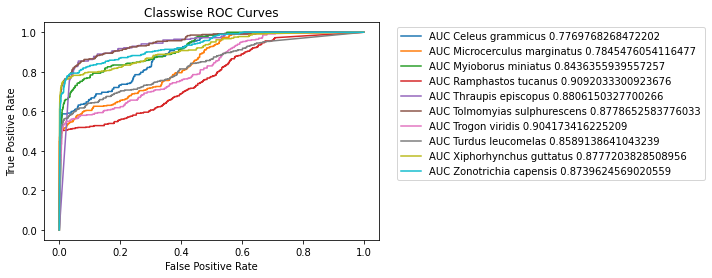

In [39]:
import matplotlib.pyplot as plt
for species in species_of_interests:
    try:
        fpr, tpr, thresh = roc_curve(label_df[species],  scores_df[species])
        auc = roc_auc_score(label_df[species],  preds_df[species])
        plt.plot(fpr,tpr,label="AUC " + species + " "+str(auc))
    except:
        continue

plt.title('Classwise ROC Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [42]:
sum(preds_df.apply(lambda x: sum(x), axis=1))

5384.0

In [43]:
preds_df

,Celeus grammicus,Microcerculus marginatus,Myioborus miniatus,Ramphastos tucanus,Thraupis episcopus,Tolmomyias sulphurescens,Trogon viridis,Turdus leucomelas,Xiphorhynchus guttatus,Zonotrichia capensis,-1
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
